## Reload KINN and CNN

In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn
# reload and re-train to full convergence
%run notebooks/reload
%matplotlib inline

from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder
from notebooks.runAmber_kinn import get_uniform_ms, get_finkelstein_ms, get_data

import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


Using TensorFlow backend.


0.1.1-ga


In [2]:
# load data
target = "wtCas9_cleave_rate_log"

res = get_data(target=target, make_switch=False)
# unpack data tuple
x_train, y_train, x1_ts, y1_ts, x_val, y_val, x2_ts, y2_ts = res

In [3]:
# load kinn
kinn_model_space = get_finkelstein_ms()
wd = "outputs/KINN-wtCas9_cleave_rate_log-finkelstein-0/"
kinn = reload_from_dir(wd, replace_conv_by_fc=False, n_channels=9)

In [4]:
# load cnn
wd = "outputs/CNN-wtCas9_cleave_rate_log-0/"
train_hist = pd.read_table(os.path.join(wd, "train_history.csv"), sep=",", header=None)
best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
dcnn = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))

## Error residuals distributions comparison

In [5]:
def make_err_plot(x, y, ax=None):
    kinn_pred = kinn.predict(x)
    cnn_pred = dcnn.predict(x)
    df = pd.DataFrame({'kinn_err':y - kinn_pred.flatten(), 'cnn_err':y - cnn_pred.flatten()}, 
                      index=np.arange(len(kinn_pred)))
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax = sns.kdeplot(x='kinn_err', y='cnn_err', data=df, ax=ax)
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="red")
    ax.axvline(0, ls="--", c="grey")
    ax.axhline(0, ls="--", c="grey")
    ax.set_xlabel("KINN error\n(mae=%.2f)"%df['kinn_err'].abs().mean())
    ax.set_ylabel("CNN error\n(mae=%.2f)"%df['cnn_err'].abs().mean())
    ax.set_title("Error residual pcc=%.3f" % ss.pearsonr(df['kinn_err'], df['cnn_err'])[0])
    return ax

Text(0.5, 1.0, 'sgRNA 1 Test\nError residual pcc=0.645')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


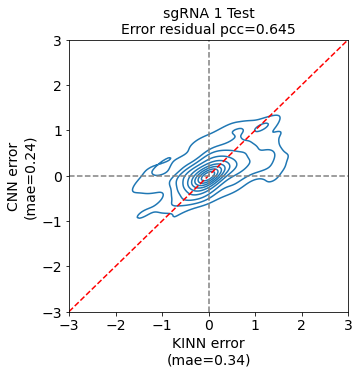

In [6]:
ax = make_err_plot(x1_ts, y1_ts)
ax.set_title("sgRNA 1 Test\n" + ax.get_title())

Text(0.5, 1.0, 'sgRNA 2 Test\nError residual pcc=0.715')

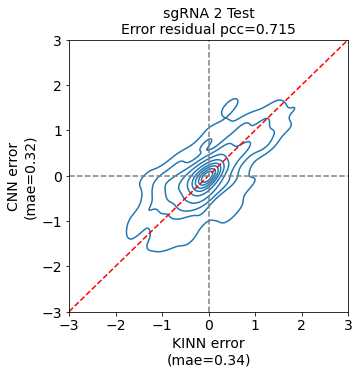

In [7]:
ax = make_err_plot(x2_ts, y2_ts)
ax.set_title("sgRNA 2 Test\n" + ax.get_title())

## In-sillico mutagenesis

In [8]:
# rate model
layer_dict = {l.name:l for l in kinn.model.layers}
rate_mod = tf.keras.models.Model(inputs=kinn.model.inputs, outputs=layer_dict['gather_rates'].output) 

In [9]:
layer_dict['output_nonneg'].get_weights()

[array([[1.026912]], dtype=float32), array([-5.0163264], dtype=float32)]

In [10]:
matched = np.zeros((1,25,9))

print("kinn matched:", kinn.predict(matched).flatten())
print("dcnn matched:", dcnn.predict(matched).flatten())

kinn matched: [-1.0877817]
dcnn matched: [-0.9846239]


In [11]:
def in_sillico_mutagen(x, model, verbose=False):
    score = np.zeros(x.shape)
    ref = model.predict(x).flatten()
    ref = np.clip(ref, -5, -1)
    for i in range(x.shape[-2]):
        for j in range(x.shape[-1]):
            x_m = x.copy()
            x_m[:,i] = 0
            x_m[:,i,j] = 1
            score[:,i,j] = ref - np.clip(model.predict(x_m).flatten(), -5, -1)
    return score.squeeze()
        

In [12]:
# get effects - s1: KINN, s2: dcnn
s1 = in_sillico_mutagen(matched, kinn)[2:]
s2 = in_sillico_mutagen(matched, dcnn)[2:]

Text(0.5, 1.0, 'Mutation effects comparison\npcc=0.914')

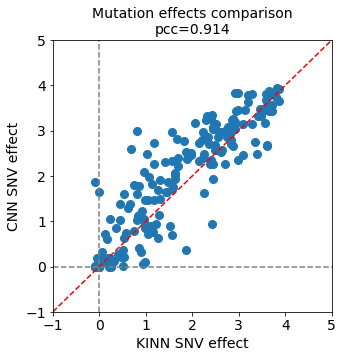

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_xlim(-1,5)
ax.set_ylim(-1,5)
ax.scatter(s1.reshape(-1), s2.reshape(-1))
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="red")
ax.set_xlabel("KINN SNV effect")
ax.set_ylabel("CNN SNV effect")
ax.axvline(0, ls="--", c="grey")
ax.axhline(0, ls="--", c="grey")
ax.set_title("Mutation effects comparison\npcc=%.3f" % ss.pearsonr(s1.reshape(-1), s2.reshape(-1))[0])

In [14]:
# no existing 2nd G deletion in training data of sgRNA1.
max(x_train[:,1,-1])

0.0

In [15]:
# Only 2nd G deletion in validation(sgRNA2) and test(sgRNA2); test(sgRNA1) is also missing
print(max(x_val[:,1,-1]))
print(max(x1_ts[:,1,-1]))
print(max(x2_ts[:,1,-1]))

1.0
0.0
1.0


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


<AxesSubplot:title={'center':'SNV in Matched: CNN'}>

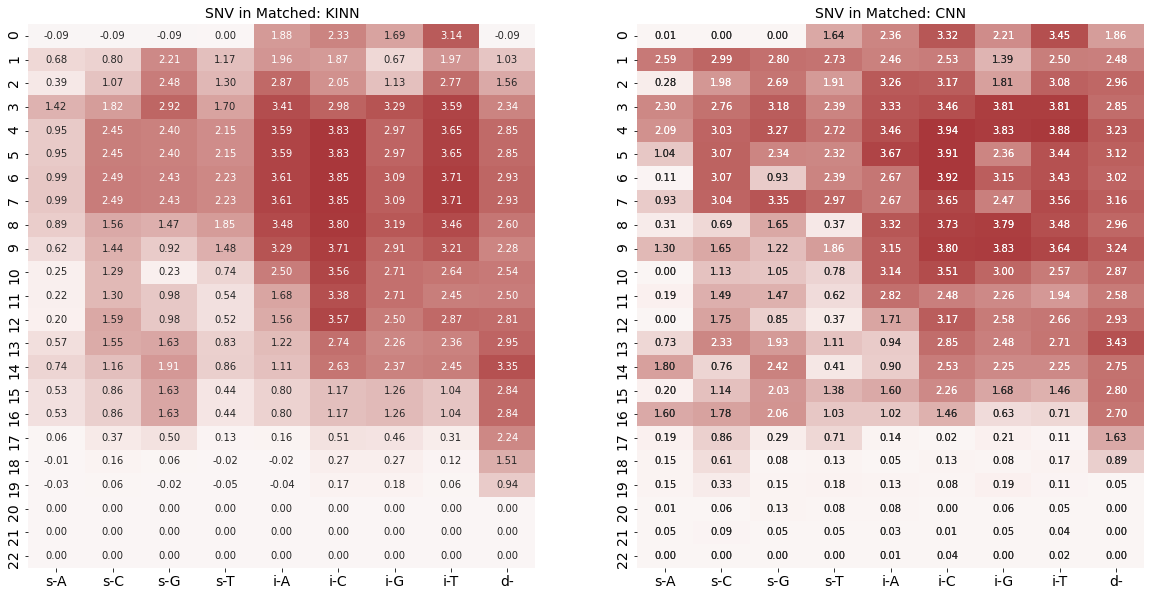

In [16]:
# thus, do not include the first 2 Gs
fig, axs = plt.subplots(1,2, figsize=(20,10))

sns.heatmap(s1, annot=True, ax=axs[0], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
)
axs[0].set_title('SNV in Matched: KINN')
sns.heatmap(s2, annot=True, ax=axs[1], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
)

axs[1].set_title('SNV in Matched: CNN')
sns.heatmap(s2, annot=True, ax=axs[1], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
)

#axs[2].set_title('SNV KINN - CNN')
#sns.heatmap(s1-s2, annot=True, ax=axs[2], center=0, cbar=False, fmt=".2f", 
#            cmap=sns.color_palette("vlag", as_cmap=True),
#            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
#)

In [17]:
s_kinn = in_sillico_mutagen(x2_ts, kinn)[:,2:]
s_dcnn = in_sillico_mutagen(x2_ts, dcnn)[:,2:]

Text(0.5, 1.0, 'SNV in Total - CNN')

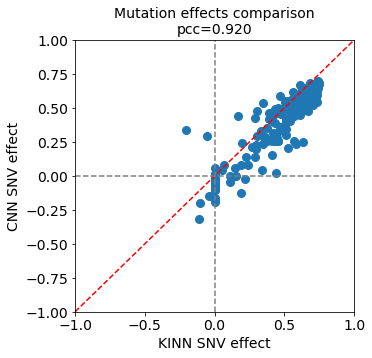

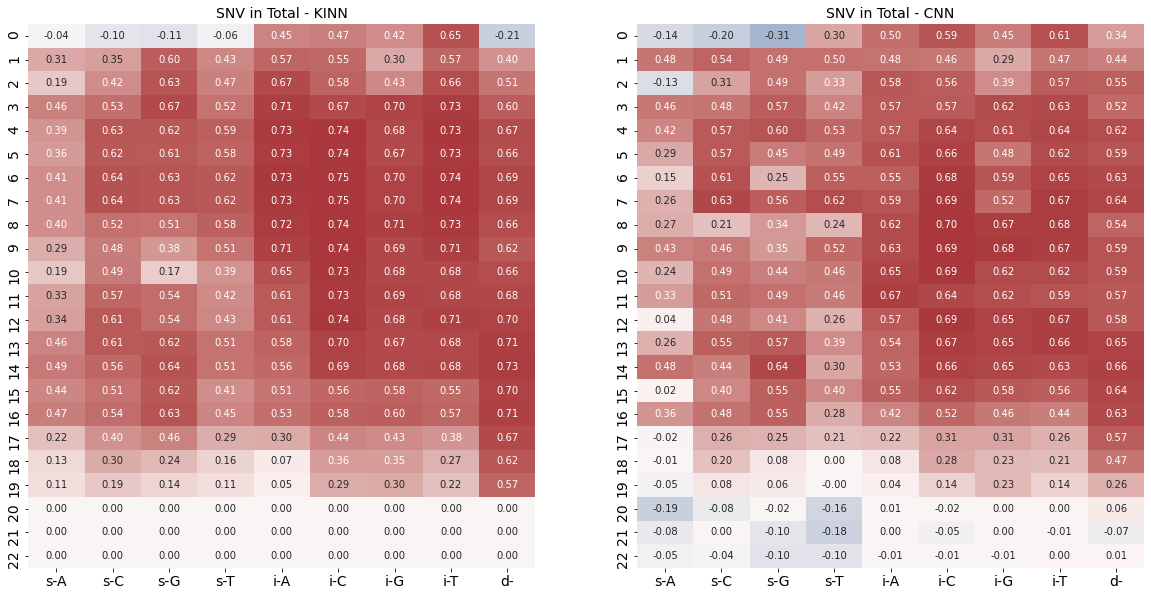

In [18]:
s1 = s_kinn.mean(axis=0)
s2 = s_dcnn.mean(axis=0)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.scatter(s1.reshape(-1), s2.reshape(-1))
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="red")
ax.set_xlabel("KINN SNV effect")
ax.set_ylabel("CNN SNV effect")
ax.axvline(0, ls="--", c="grey")
ax.axhline(0, ls="--", c="grey")
ax.set_title("Mutation effects comparison\npcc=%.3f" % ss.pearsonr(s1.reshape(-1), s2.reshape(-1))[0])

fig, axs = plt.subplots(1,2, figsize=(20,10))
sns.heatmap(s1, annot=True, ax=axs[0], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
)
axs[0].set_title('SNV in Total - KINN')
sns.heatmap(s2, annot=True, ax=axs[1], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
)
axs[1].set_title('SNV in Total - CNN')

In [19]:
def pretty_print(mat):
    for i, r in enumerate(mat):
        sub, indel = r[0:4], r[4:]
        if sum(sub) == 0:
            s = ''
        else:
            s = 'sub:' + 'ACGT'[np.where(sub==1)[0][0]]
        if sum(indel) == 0:
            ind = ''
        else:
            ind = 'indel:' + 'ACGT-'[np.where(indel==1)[0][0]]
        
        if not s and not ind:
            m = "match"
        else:
            m = ''
        print('row %i\t'%i, m, s, ind)
        #print('row ', i, r)

pretty_print(x2_ts[523])

row 0	  sub:C 
row 1	  sub:T 
row 2	  sub:A 
row 3	 match  
row 4	 match  
row 5	 match  
row 6	 match  
row 7	 match  
row 8	 match  
row 9	 match  
row 10	 match  
row 11	 match  
row 12	 match  
row 13	 match  
row 14	 match  
row 15	 match  
row 16	 match  
row 17	 match  
row 18	 match  
row 19	 match  
row 20	 match  
row 21	 match  
row 22	 match  
row 23	 match  
row 24	 match  


In [20]:
kinn.predict(x2_ts[[523]]), dcnn.predict(x2_ts[[523]]), y2_ts[523]

(array([[-5.0147295]], dtype=float32),
 array([[-5.054492]], dtype=float32),
 -5.0)